In [15]:
################################
# Scientific imports
################################
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries

###
# General imports
###
import csv, math, io, os, os.path, sys, random, time
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

###
# SciKitLearn Imports
###
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (20,9)
sb.set()

################################
# Suppress Warnings
################################
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

################################
# Initialisers
################################

# Load the Data files
fitsarr = np.load("fitslist.npy")
#foldedfluxarr = np.load("foldedflux.npy")
fluxarr = np.load("None_Or_One_Exoplanet_NORMALISED.npy")
#planetarr = np.load("planetlist.npy")
#isplanetarr = np.load("isplanetlist.npy")

In [16]:
def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    #ylab = "PDCSAP Flux (e-/s)"
    ylab = "SAP Flux (e-/s)"
    xlab = "Time (TBJD)"

                        # pdcsap_fluxes[1:-1]
    return (tess_bjds[1:-1], sap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)

Text(0, 0.5, 'SAP Flux (e-/s)')

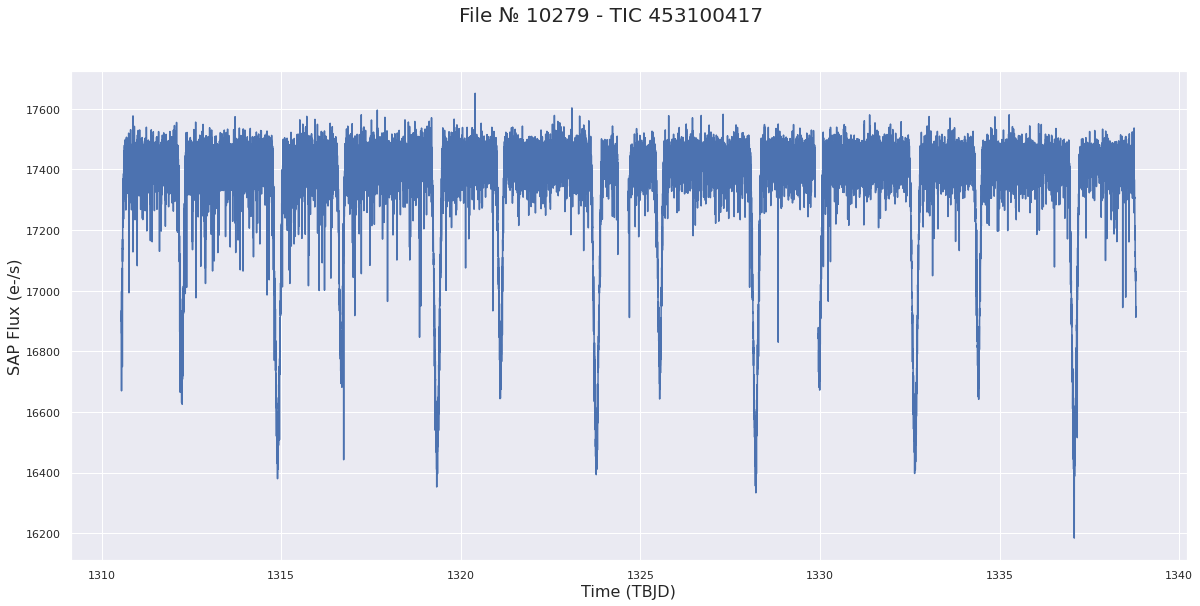

In [3]:
x,y,f,o,s,ylab,xlab = DrawLC(10279)

fig, ax = plt.subplots()
ax.plot(x,y)
fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))
ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel(ylab, fontsize=16)

Text(0, 0.5, 'SAP Flux (e-/s)')

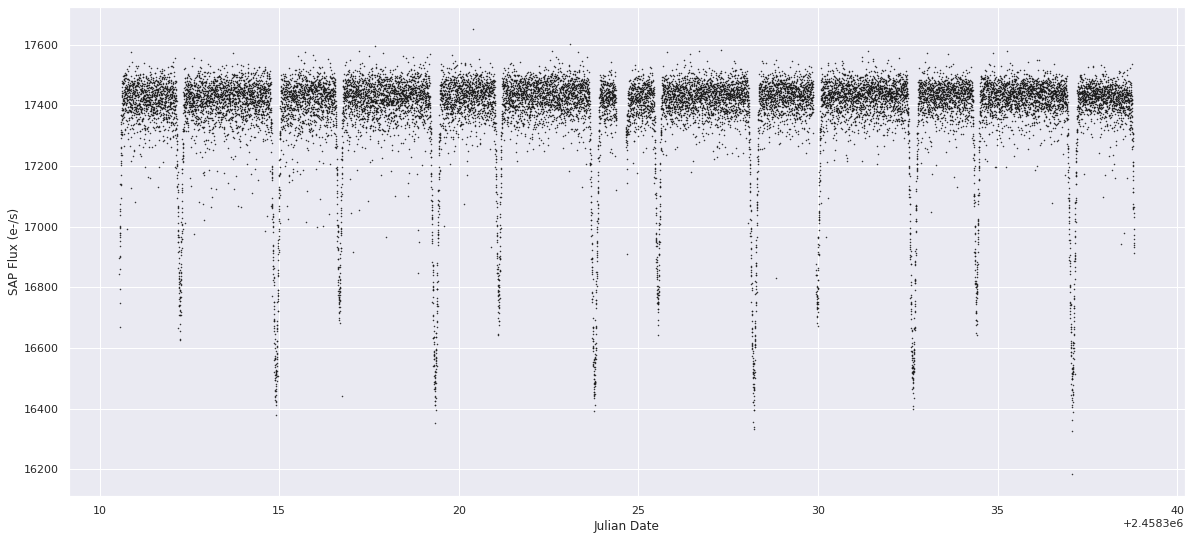

In [6]:
f = 10279

ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')

plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

PERIOD: 4.440662166145974
TRANSIT TIME: 2018-07-15T09:22:42.917


Text(0, 0.5, 'SAP Flux (e-/s)')

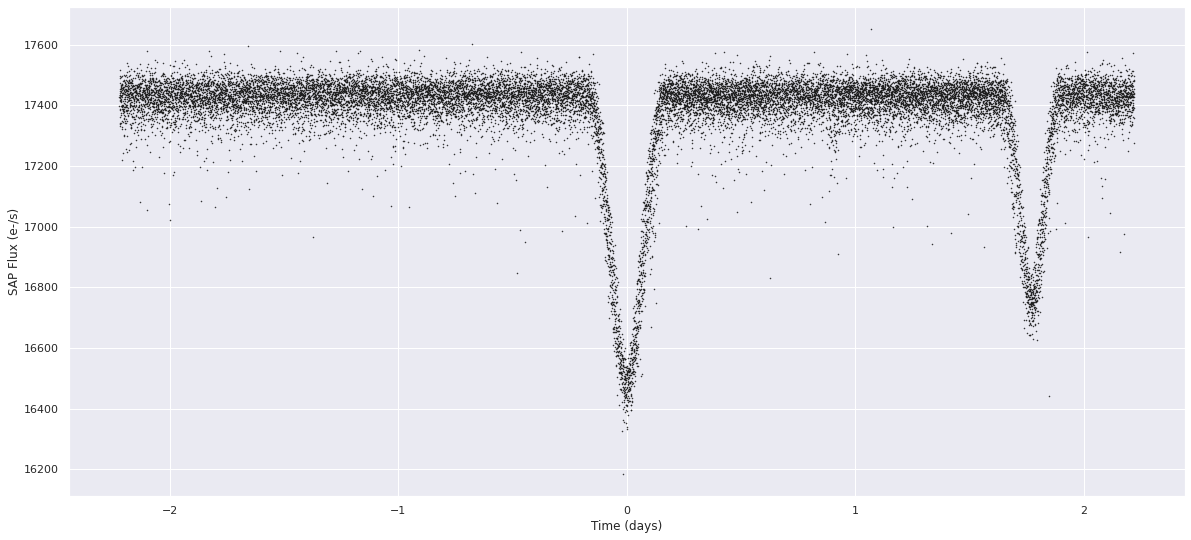

In [7]:
results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]  
print("PERIOD: {}".format(period.value))

transit_time = results.transit_time[best]  
print("TRANSIT TIME: {}".format(transit_time))

ts_folded = ts.fold(period=period, epoch_time=transit_time)

plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

/home/jdowzell/anaconda3/lib/python3.8/site-packages/astropy/timeseries/downsample.py:28: RuntimeWarning: Mean of empty slice
  result.append(function(array[indices[i]:indices[i+1]]))
/home/jdowzell/anaconda3/lib/python3.8/site-packages/astropy/timeseries/downsample.py:29: RuntimeWarning: Mean of empty slice
  result.append(function(array[indices[-1]:]))


   time_bin_start     time_bin_size   ...   sap_flux_norm   
                            s         ...                   
------------------- ----------------- ... ------------------
-2.2201145242777387 86.40000000000008 ... 0.9992559552192688
 -2.219114524277739 86.40000000000008 ... 1.0017955303192139
-2.2181145242777385 86.40000000000008 ... 0.9972079396247864
-2.2171145242777386 86.40000000000008 ... 0.9985089302062988
-2.2161145242777387 86.40000000000008 ...  1.001042127609253
 -2.215114524277739 86.40000000000008 ... 0.9994537830352783
-2.2141145242777385 86.40000000000008 ...  1.000430703163147
-2.2131145242777386 86.40000000000008 ... 0.9995414018630981
-2.2121145242777387 86.40000000000008 ... 0.9997934699058533
 -2.211114524277739 86.40000000000008 ... 0.9989129304885864
                ...               ... ...                ...
 2.2108854757224936 86.40000000002405 ...  1.000313639640808
 2.2118854757224935 86.40000000002405 ... 0.9986766576766968
  2.212885475722494 86.4

Text(0, 0.5, 'Normalized flux')

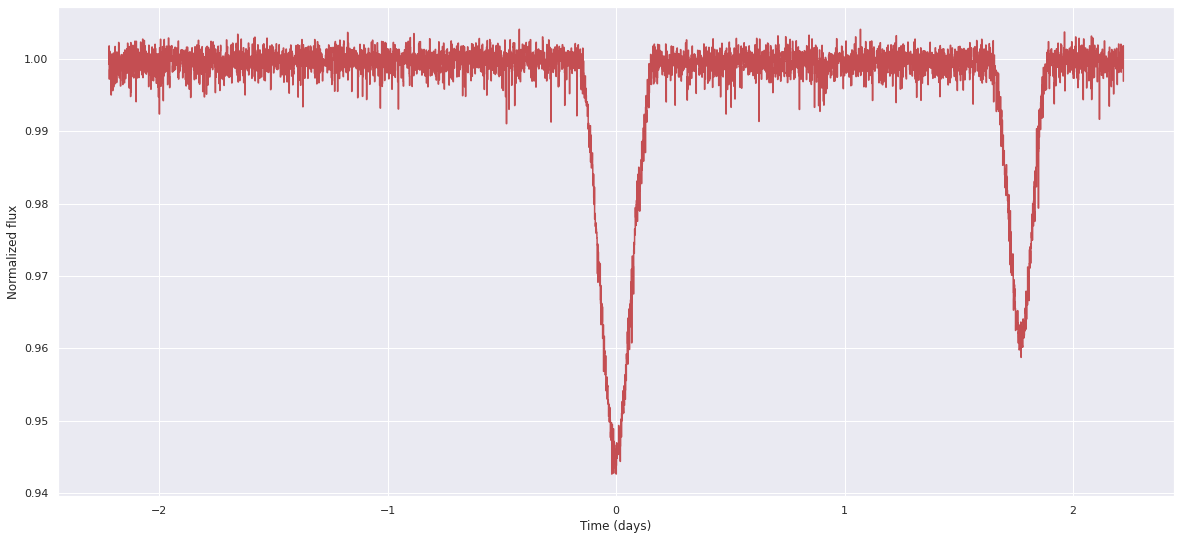

In [13]:
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample

mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])  
ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median

ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.001 * u.day)  
print(ts_binned)

#plt.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
plt.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], 'r-', markersize=0.5, drawstyle='steps-post')
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')

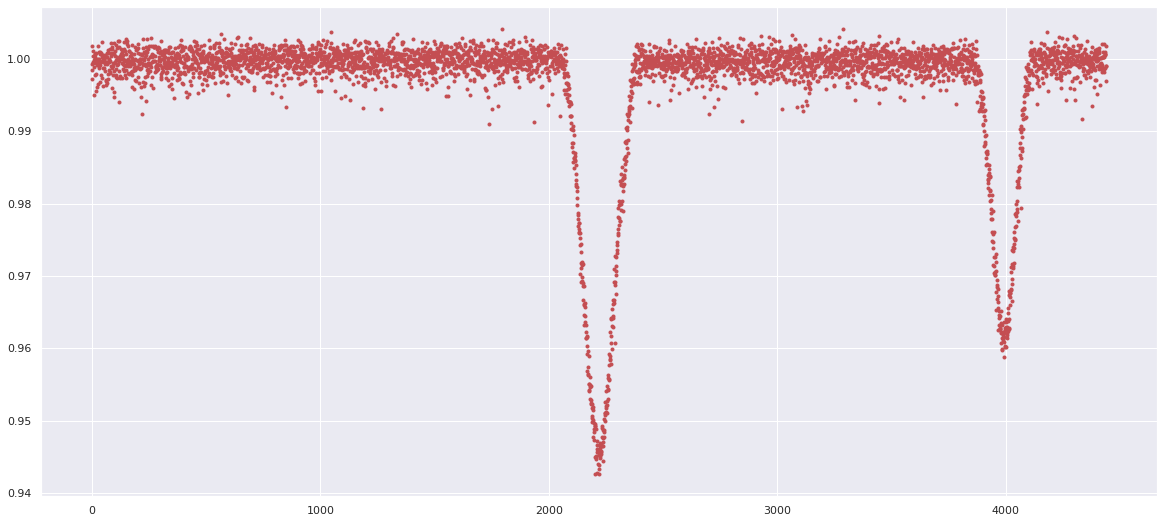

In [14]:
plt.plot(ts_binned['sap_flux_norm'],'r.')

### So I only need to get to TS_BINNED in order to get the data points I need